In [53]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Add the 'oracle' directory to the Python path
sys.path.append(os.path.join(os.getcwd(), 'oracle'))
import oracle

In [54]:
res = oracle.q1_fish_train_test_data(23607)
print(res[0])

('Wearing_Lipstick', 'Big_Lips')


In [55]:
attributes = res[0]
train_img = np.array(res[1])
train_labels = np.array(res[2])
test_img = np.array(res[3])
test_labels = np.array(res[4])

In [56]:
# flatten the images
train_img = train_img.reshape(train_img.shape[0], -1)
test_img = test_img.reshape(test_img.shape[0], -1)

In [57]:
train_img_0 = train_img[train_labels == 0]
train_img_1 = train_img[train_labels == 1]
train_img_2 = train_img[train_labels == 2]
train_img_3 = train_img[train_labels == 3]

test_img_0 = test_img[test_labels == 0]
test_img_1 = test_img[test_labels == 1]
test_img_2 = test_img[test_labels == 2]
test_img_3 = test_img[test_labels == 3]

In [58]:
c = 4 # number of classes

def fld_w(train_img, n):
    W_T = []

    train_img_0_n = train_img[0][:n]
    train_img_1_n = train_img[1][:n]
    train_img_2_n = train_img[2][:n]
    train_img_3_n = train_img[3][:n]

    m0_n = np.mean(train_img_0_n, axis=0)
    m1_n = np.mean(train_img_1_n, axis=0)
    m2_n = np.mean(train_img_2_n, axis=0)
    m3_n = np.mean(train_img_3_n, axis=0)

    # # Calculate scatter matrices using the proper formula: S = ∑ (x - m) (x - m)^T
    s0_n = np.cov(train_img_0_n.T)*n
    s1_n = np.cov(train_img_1_n.T)*n
    s2_n = np.cov(train_img_2_n.T)*n
    s3_n = np.cov(train_img_3_n.T)*n

    s_W_n = s0_n + s1_n + s2_n + s3_n

    means = np.array([m0_n, m1_n, m2_n, m3_n])
    m = np.mean(means, axis=0)
    s_B_n = np.zeros((train_img_0_n.shape[1], train_img_0_n.shape[1]))
    for i in range(c):
        diff = (means[i] - m).reshape(-1, 1)
        s_B_n += n * np.dot(diff, diff.T)
    
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(s_W_n).dot(s_B_n))
    eigvals = eigvals.real
    eigvecs = eigvecs.real

    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    W_T.append(eigvecs[:, :c-1]) # We take the first c-1 eigenvectors
    return W_T

In [59]:
def accuracy(test_img, test_labels, w, train_img_n, n):
    w = fld_w(train_img_n, n)

    train_img_0_proj = train_img_n[0].dot(w[0])
    train_img_1_proj = train_img_n[1].dot(w[0])
    train_img_2_proj = train_img_n[2].dot(w[0])
    train_img_3_proj = train_img_n[3].dot(w[0])

    m0_proj = np.mean(train_img_0_proj, axis=0)
    m1_proj = np.mean(train_img_1_proj, axis=0)
    m2_proj = np.mean(train_img_2_proj, axis=0)
    m3_proj = np.mean(train_img_3_proj, axis=0)

    cov0_proj = np.cov(train_img_0_proj.T)
    cov1_proj = np.cov(train_img_1_proj.T)
    cov2_proj = np.cov(train_img_2_proj.T)
    cov3_proj = np.cov(train_img_3_proj.T)

    false_count = 0
    class_pred = []

    for x in test_img:
        x_proj = x.dot(w[0])
        posteriors = [
            np.exp(-0.5 * np.dot(np.dot((x_proj - m0_proj), np.linalg.inv(cov0_proj)), (x_proj - m0_proj).T)),
            np.exp(-0.5 * np.dot(np.dot((x_proj - m1_proj), np.linalg.inv(cov1_proj)), (x_proj - m1_proj).T)),
            np.exp(-0.5 * np.dot(np.dot((x_proj - m2_proj), np.linalg.inv(cov2_proj)), (x_proj - m2_proj).T)),
            np.exp(-0.5 * np.dot(np.dot((x_proj - m3_proj), np.linalg.inv(cov3_proj)), (x_proj - m3_proj).T))
        ]
        class_pred.append(np.argmax(posteriors))

    class_pred = np.array(class_pred)
    false_count = np.sum(class_pred != test_labels)  


    return false_count/len(test_labels)

In [60]:
n_all = [2500, 3500, 4000, 4500, 5000]
for n in n_all:
    #random sample n images from each class
    train_0 = train_img_0[np.random.choice(train_img_0.shape[0], n, replace=False)]
    train_1 = train_img_1[np.random.choice(train_img_1.shape[0], n, replace=False)]
    train_2 = train_img_2[np.random.choice(train_img_2.shape[0], n, replace=False)]
    train_3 = train_img_3[np.random.choice(train_img_3.shape[0], n, replace=False)]
    train_img_n = [train_0, train_1, train_2, train_3]

    print(accuracy(test_img, test_labels, fld_w(train_img_n, n), train_img_n, n), "for n =", n)

0.508 for n = 2500
0.46 for n = 3500
0.443 for n = 4000
0.455 for n = 4500
0.441 for n = 5000


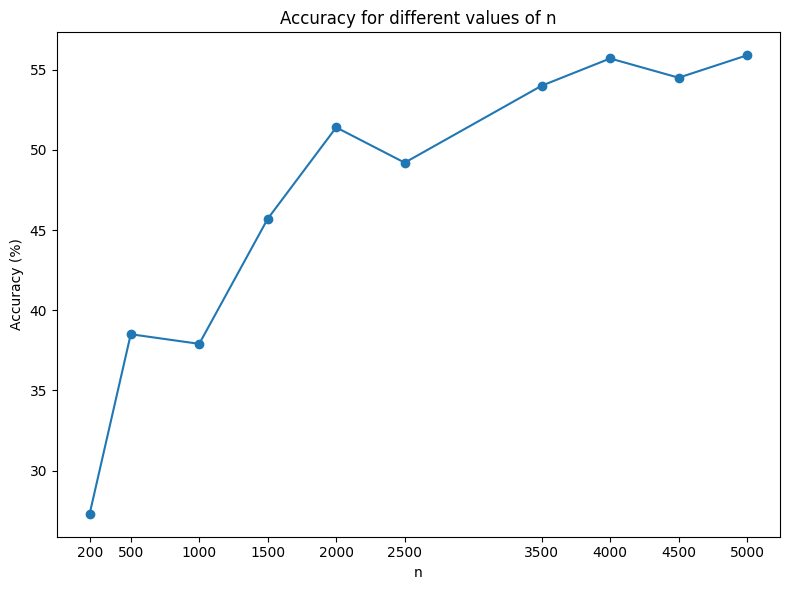

In [63]:
import matplotlib.pyplot as plt

n_values = [200, 500, 1000, 1500, 2000, 2500, 3500, 4000, 4500, 5000]
accuracy_values = [27.300, 38.500, 37.900, 45.700, 51.400, 49.200, 54.000, 55.700, 54.500, 55.900]

plt.figure(figsize=(8, 6))
plt.plot(n_values, accuracy_values, marker='o', linestyle='-')

plt.xlabel('n')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for different values of n')
# plt.grid(True)
plt.xticks(n_values) # Show all n values on x-axis for better readability
plt.tight_layout()
plt.show()